# Food101 Challenge

**Task:**<br>Food 101 is a labelled data set with 101 different food classes. Each food class contains 1000 images. Using the data provided,  a Machine Learning Model that can classify 3 classes in Food 101 dataset is created.

**The Setting:**
<br>**Classes: **(Apple_pie, Baby_back_ribs, Baklava)
<br>**Epoches: **100
<br>**Batch_size:** 64

In [18]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K

import os

#### Get the paths of the images and the train-test image files for each category

In [3]:
# find file paths
food = ['apple_pie','baby_back_ribs', 'baklava'] 
f_apple = glob.glob('../input/food102/food101/food101/train/'+food[0]+'/*')
f_baby = glob.glob('../input/food102/food101/food101/train/'+food[1]+'/*')
f_baklava = glob.glob('../input/food102/food101/food101/train/'+food[2]+'/*')
f_apple_test = glob.glob('../input/food102/food101/food101/test/'+food[0]+'/*')
f_baby_test = glob.glob('../input/food102/food101/food101/test/'+food[1]+'/*')
f_baklava_test = glob.glob('../input/food102/food101/food101/test/'+food[2]+'/*')
# total 1000 files for each category
print('Number of images per class:\n\t\ttrain\ttest \nApple_pie:\t{}\t{}\nBaby_pork_ribs:\t{}\t{}\nBaklava:\t{}\t{}'
      .format(len(f_apple),len(f_apple_test),len(f_baby),len(f_baby_test),len(f_baklava),len(f_baklava_test)))

Number of images per class:
		train	test 
Apple_pie:	750	250
Baby_pork_ribs:	750	250
Baklava:	750	250


# EDA

#### Let's get an idea of the images of the 3 categories. As we see here, the quality of the images are not very good: with different background (noise), different lightings and even wrong labels (e.g. empty plate in the first pic of the baklava, missing apple pie in the last apple pie pic).

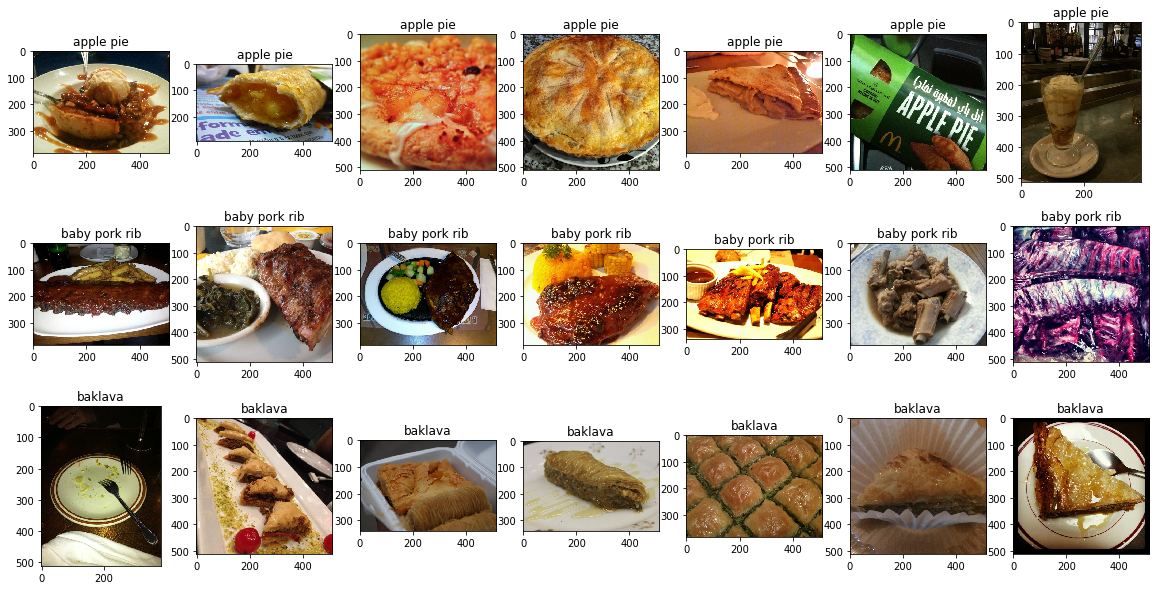

In [4]:
# preview some images of each class
n = 7
fig, axes = plt.subplots(3,n,figsize=(20,10))

for i in range(n):
    axes[0, i].imshow(plt.imread(f_apple[i]))
    axes[0, i].set_title('apple pie')
    axes[1, i].imshow(plt.imread(f_baby[i]))
    axes[1, i].set_title('baby pork rib')
    axes[2, i].imshow(plt.imread(f_baklava[i]))
    axes[2, i].set_title('baklava')

#### The images are of different sizes and aspect ratio, with at least one side of 512 pixels.

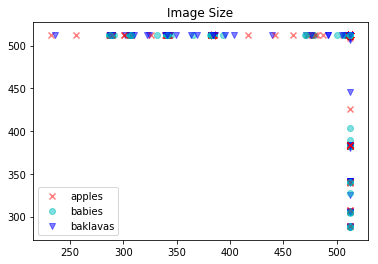

In [5]:
for i in range(len(f_apple)):
    h1,w1,c1 = plt.imread(f_apple[i]).shape
    h2,w2,c2 = plt.imread(f_baby[i]).shape
    h3,w3,c3 = plt.imread(f_baklava[i]).shape
    plt.scatter(h1,w1,c='r',marker='x',alpha=0.5)
    plt.scatter(h2,w2,c='c',marker='o',alpha=0.5)
    plt.scatter(h3,w3,c='b',marker='v',alpha=0.5)
plt.title('Image Size')
plt.legend(('apples','babies','baklavas'))

# Data Augmentation

#### In order to avoid overfitting problem and to expand the dataset. Image data generator from Keras is used for image tranformation.

In [6]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5,
                 width_shift_range=0.05,
                 height_shift_range=0.05,
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #rescale to [0-1], add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory(
        "../input/food102/food101/food101/train",
        target_size=(224,224),
        batch_size=64)
test_datagen = ImageDataGenerator(rescale=1/255) # just rescale to [0-1] for testing set
test_generator = test_datagen.flow_from_directory(
        "../input/food102/food101/food101/test",
        target_size=(224,224),
        batch_size=64)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


#### Just to make sure the image generator is working and the transformation is acceptable.

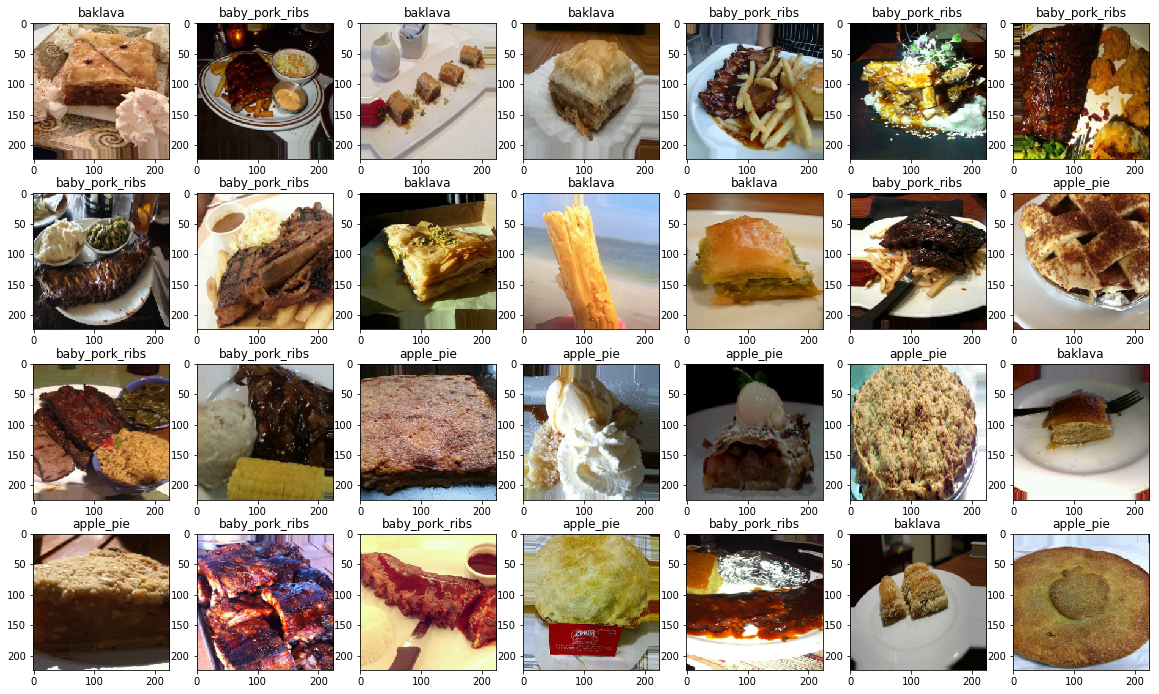

In [7]:
# preview images from train generator
r = 4; c = 7
n=0
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava'}
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

# Modelling

In [58]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)        0         
__________

In [21]:
history = model.fit_generator(train_generator,steps_per_epoch=2250/64,
                              validation_data=test_generator,validation_steps=750/64, 
                              epochs=100, callbacks=[checkpointer, reduceLR, earlystopping])

Epoch 1/100
36/35 [==============================] - 48s 1s/step - loss: 1.1511 - acc: 0.3457 - val_loss: 1.1083 - val_acc: 0.5280

Epoch 00001: val_loss improved from inf to 1.10827, saving model to model.hdf5
Epoch 2/100
 4/35 [==>...........................] - ETA: 4s - loss: 1.0962 - acc: 0.4414

KeyboardInterrupt: 

In [23]:
# # load weights from upload files
# model.load_weights('../input/model-v17/model_v17.hdf5')

# load weights from training with lowest val_loss
# model.load_weights('../working/model.hdf5')

In [60]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['acc'],c='C2')
    ax[0].plot(history.history['val_acc'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

NameError: name 'history' is not defined

# Evaluate results

In [24]:
# create another generator for all test images in a single batch 
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = test_datagen.flow_from_directory(
        "../input/food102/food101/food101/test",
        target_size=(224,224),
        batch_size=750)

Found 750 images belonging to 3 classes.


In [25]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 78.9%


### Randomly check 5 predictions

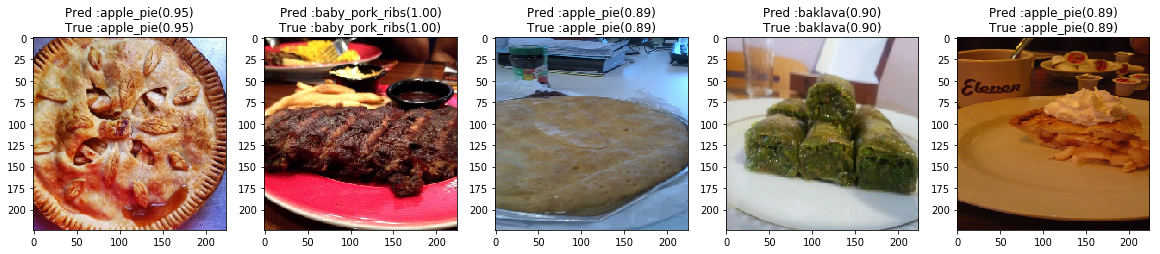

In [26]:
ind = np.random.randint(1,len(x_test),5)
f, ax=plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    ax[i].imshow(x_test[j])
    ax[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))


### Confusion Matrix

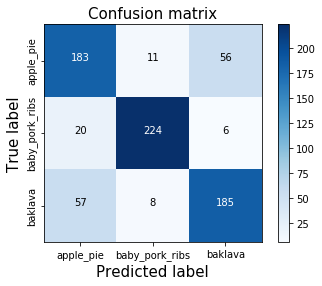

In [27]:
def plot_confusion_matrix(cm):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['apple_pie','baby_pork_ribs','baklava']
    plt.xticks([0,1,2], classes, fontsize=10)
    plt.yticks([0,1,2], classes, fontsize=10,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

### ROC Curve

In [29]:
fpr = dict() # false positive rate
tpr = dict() # true positive rate
roc_auc = dict() # area under roc curve
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_conf[:, i]) # roc_curve function apply to binary class only
    roc_auc[i] = auc(fpr[i], tpr[i])  # using the trapezoidal rule to get area under curve

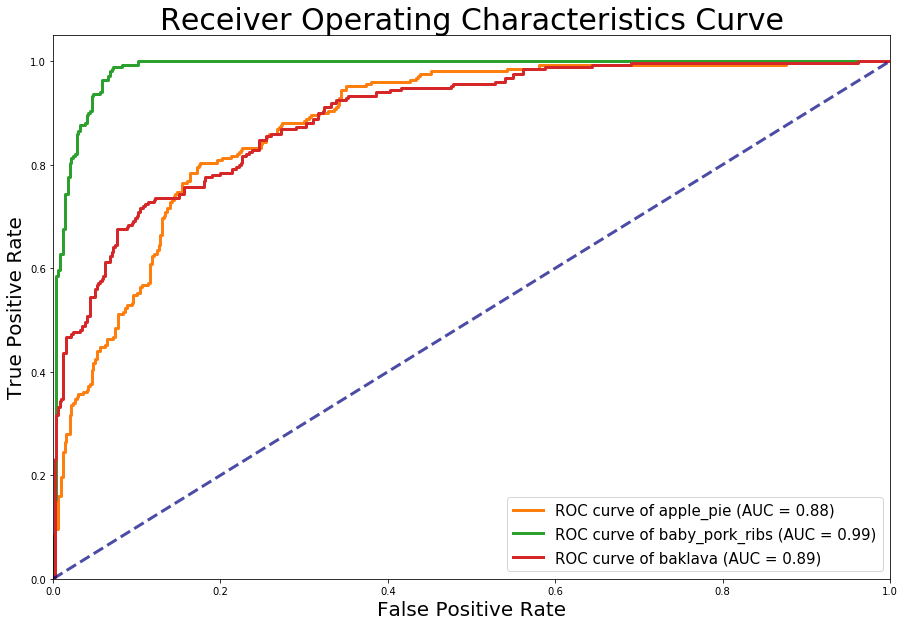

In [61]:
def plot_roc(fpr,tpr,roc_auc):
    plt.figure(figsize=(15,10))
    plt.plot(fpr[0], tpr[0], color='C1', lw=3, label='ROC curve of apple_pie (AUC = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='C2', lw=3, label='ROC curve of baby_pork_ribs (AUC = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color='C3', lw=3, label='ROC curve of baklava (AUC = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--',alpha=0.7)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.title('Receiver Operating Characteristics Curve',fontsize=30)
    plt.legend(loc="lower right",fontsize=15)
    plt.show()

plot_roc(fpr,tpr,roc_auc)

### Inspect the predictions with wrong labels

In [32]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

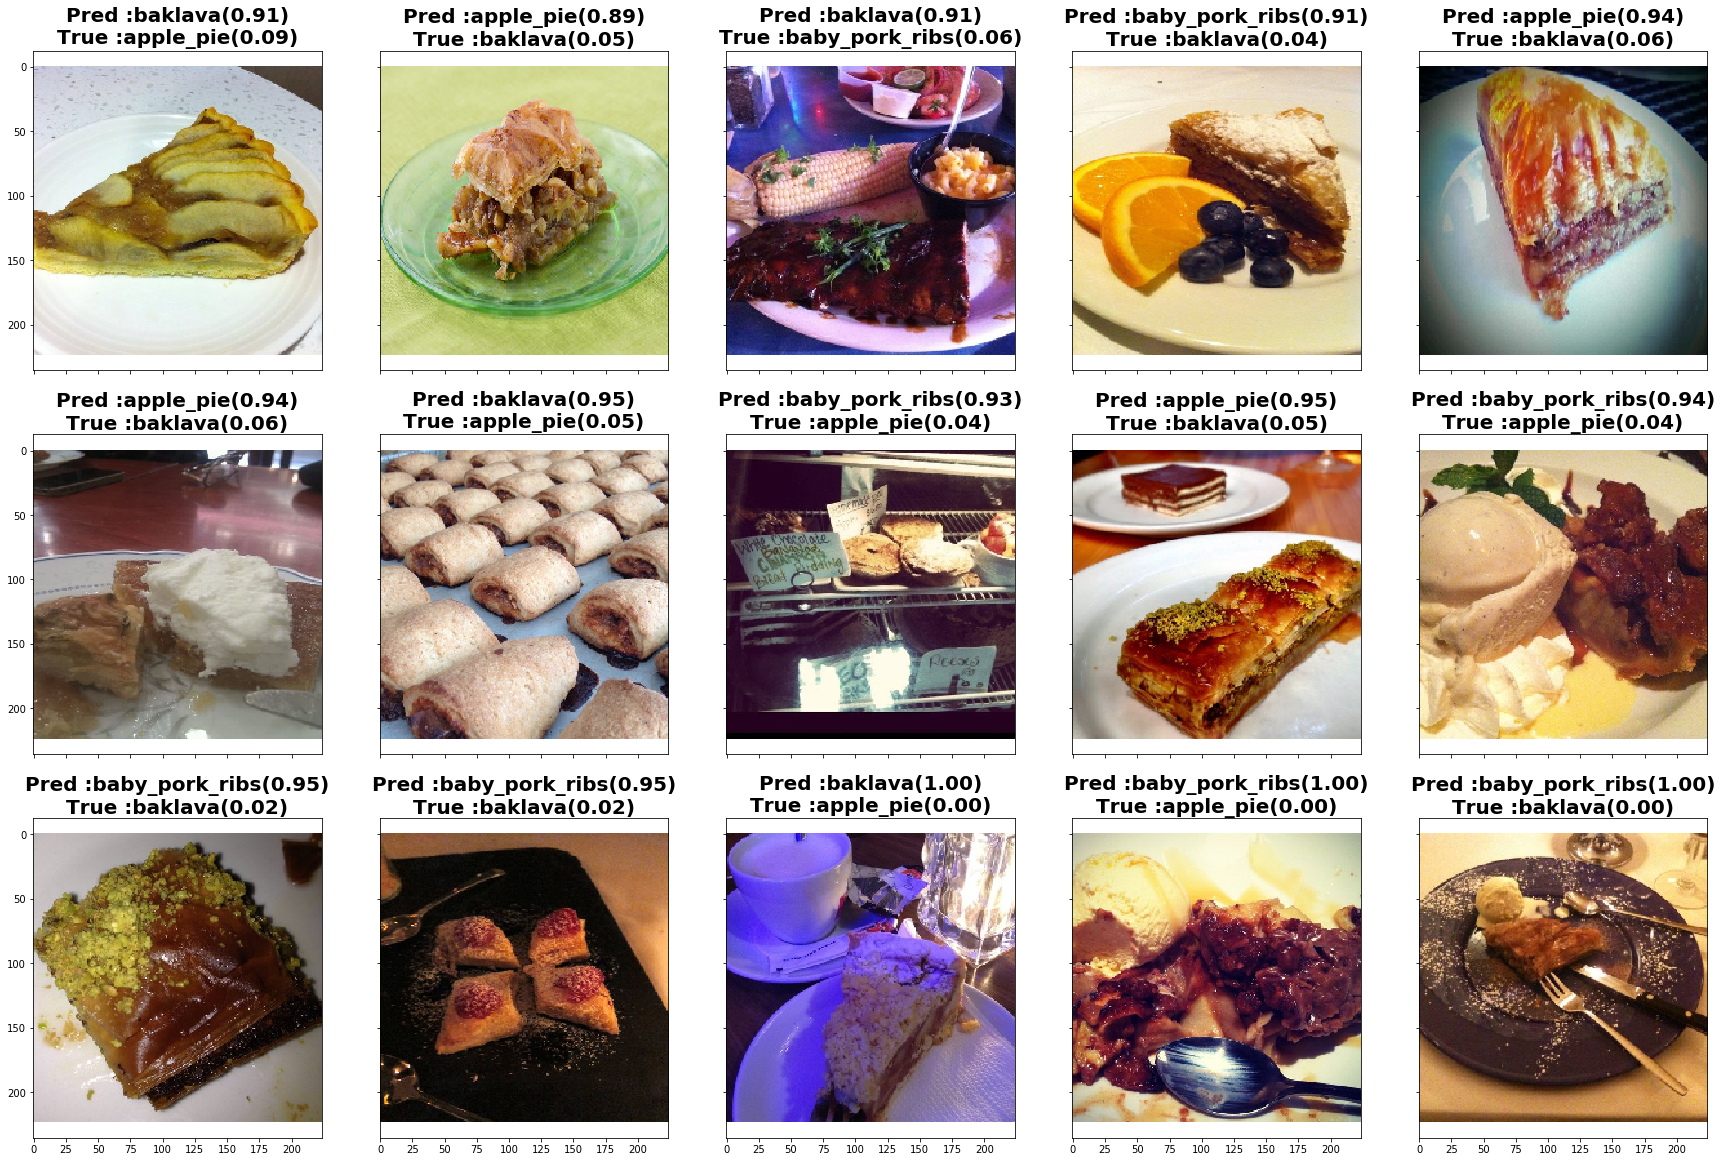

In [33]:
show_wrongest_label(x_test,y_test,y_pred_conf)

# Gradient weighted Class Activation Map

In [63]:
# define last convolution layer
last_conv_layer = model.layers[-5]


def get_grad_cam(img): # function for getting the gradient class attention map
    # predict class of the image
    y_preds = model.predict(np.expand_dims(img,axis=0))
    y_pred_class = np.argmax(y_pred[0])
    # prediction vector of the predicted class
    class_output = model.output[:, y_pred_class]
    # gradient of the predicted class with regard to the output feature map from last conv layer
    # shape of (-1,7,7,256)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    # vector of shape (256,)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    # create backend function to get values when input image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(img,axis=0)])
    # multiplies each channel in the feature map by 'how important this channel is' 
    # regard to the predicted class
    for i in range(256):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    # to visualise (7, 7, 256), mean over all channels
    gcam = np.mean(conv_layer_output_value, axis=-1)
    
    # gcam = minmax_scaling(gcam,columns=[0,1,2,3,4,5,6])
    
    # ignore all negative values
    gcam = np.maximum(gcam, 0)
    # normalise to [0-1] scale
    gcam /= np.max(gcam)
    # resize to original size image (7,7) to (224,224)
    
    gcam = scipy.ndimage.zoom(gcam, (224/7,224/7), order=1)
    return gcam

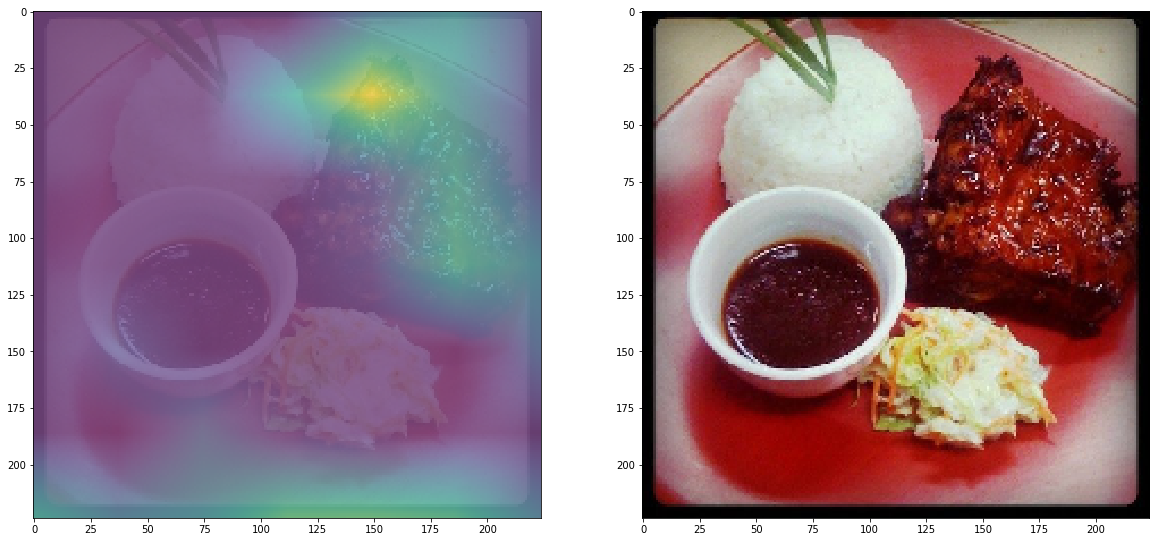

In [75]:
f, ax=plt.subplots(1,2,figsize=(20,10))

n=50

ax[0].imshow(x_test[n],alpha=0.4)
ax[0].imshow(get_grad_cam(x_test[n]),alpha=0.6)
ax[1].imshow(x_test[n])